# PhotoFiTT: Cell activity analysis

Before using this notebook make sure that you have the following:
- Raw data from the microscope (or downsampled if the magnification was too big). Note that calculating the cell activity takes a considerable amount of time (> 1h) depending on the length of each video and the size of the images.

## Data structure:
- Data has to be organised in folders by `replica > illumination condition > light dose`. Alternatively, one could have it for other conditions such as `replica > drug > concentration`. Check the schema as follows.
- Each hierarchical level in the data is encoded as `"Subcategory-XX"` in the code. The Subcategories are used to display the data analysis results. The labels will be identical to the folder name, so the same conditions should always have the same folder name. For example `WL 475 light` folder name for the folders containing data illuminated with a wavelength of 475 nm in replicas 1 and 2. This applies to all the hierarchical levels.
- Alternatively, one could rename these columns using the `pandas dataframe` functionalities in the code.

   ```   
   -Raw-images (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcategory-00]
        |
        |--Cell density / UV Light / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Light / WL 475 light [Subcategory-01]
        ...
   ```
## Example data
Two types of data are provided to test the notebooks:

- A `csv` file to reproduce the plots and results from our study with synchronised cells. When using this, one could skip calculating the  cell activity (Section 1). indicating the correct paths in Section 0, one can directly jump to Section 2.
- Example data to start using the notebooks from scratch.

## 0. Import required dependencies

In [5]:
import os
import numpy as np
import pandas as pd
import photofitt
from photofitt import display
from photofitt.analysis import extract_activity, cumulative_activity, estimate_proportional_deviations
from photofitt.utils import power_conversion, numerical_dose
import seaborn as sns
import matplotlib.pyplot as plt

### 0.1. Set the paths to the data and the output folders
- `path2images`: The path where the Raw-images are saved. Equivalent to "Masks (folder)" in our hierarchy. This folder should contain all the biological replicas and subsequent folders. For example "/home/ocb/HardDrive_4TB/PHX/SYNCHRO/Raw-images"
- `path2results`: The path where the notebook will save all the results. Once the cell activity is calculated, a CSV file together with the plots will be stored there.
- `frame_rate`: The time frame in the videos given in minutes (e.g., one frame every 4 minutes equals `frame_rate = 4`)


In [6]:
path2images = "/Users/esti/Library/CloudStorage/OneDrive-igc.gulbenkian.pt/Manuscript - PhotoFiTT/Manuscript - PhotoFiTT/PAPER/example-data-github/example-data-notebooks/downsample_data"
path2results = "/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/cell-activity/"
frame_rate = 4 

## Prepare the directory to save the results
os.makedirs(path2results,exist_ok=True)
os.makedirs(os.path.join(path2results, "plots"), exist_ok=True)


## 1. Calculate cell activity.
This process can take a long time (hours) depending on the number of videos to analyse. If it is already calculated, do not run this cell again and jump to the next step

In [ ]:
activity_metrics = extract_activity(path2images,
                                    method="intensity",
                                    save_steps=False,
                                    enhance_contrast=True,
                                    output_path=path2results,
                                    frame_rate=frame_rate,
                                    condition=None)

## Save the results
activity_metrics.to_csv(os.path.join(path2results, "data_activity_intensity.csv"))

## 2. Analyse cell activity


### 2.1 Inspect the cell activity across time
- `hue`: Choose the data level (or condition) to display the data. For example `"Subcategory-02"`
- `hue_order`: Indicate the order of the conditions in which the data should be displayed. For example `"['0 jcm2', '6 jcm2', '60 jcm2']"`. To recover the conditions available in the data, you can run `np.unique(activity_metrics["Subcategory-02"])`.
- `y_lim`: The boundary limits to display all the data in the same interval. For example `[0.0001, 0.0035]`.
- `format_extension`: Whether to save the plots as pdf (`"pdf"`) or PNG (`"png"`).

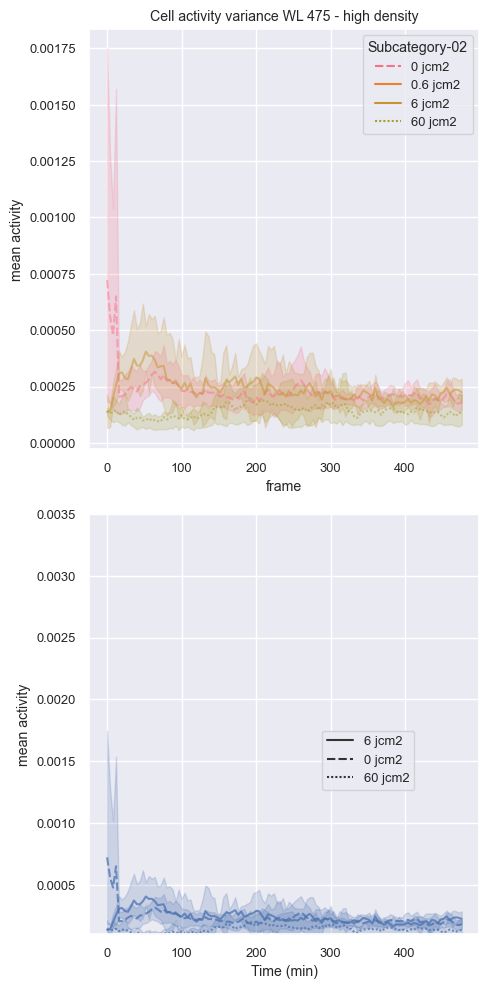

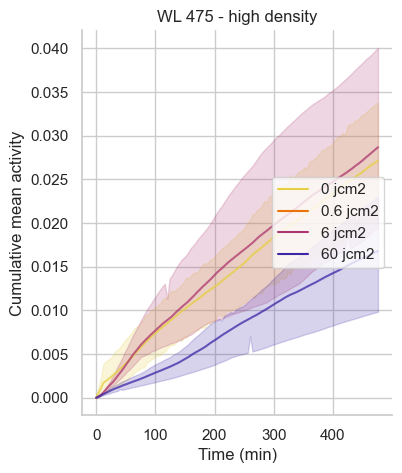

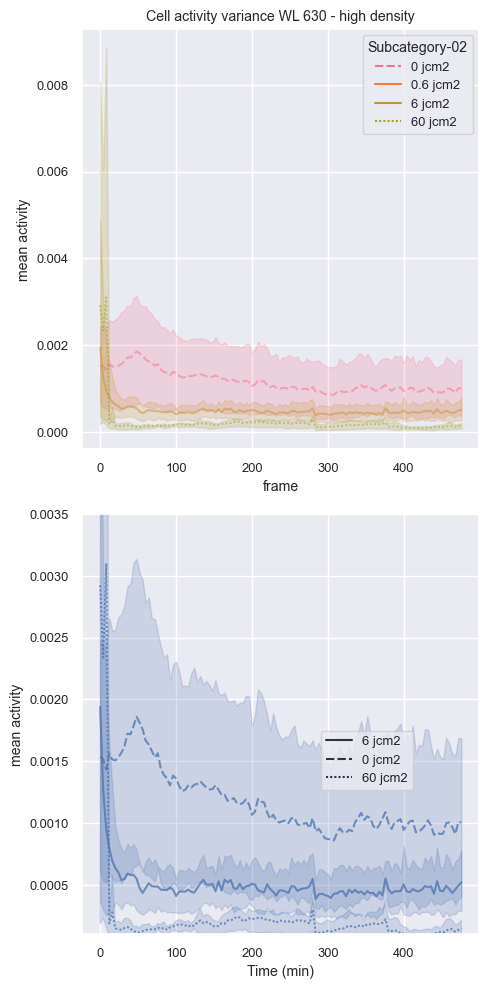

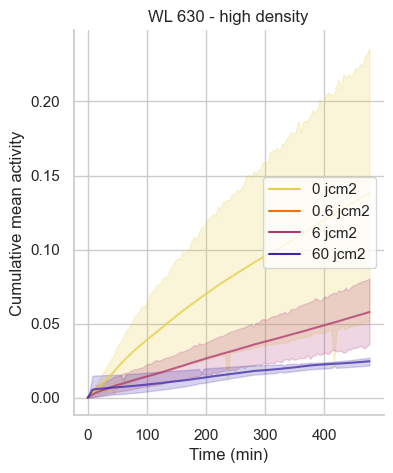

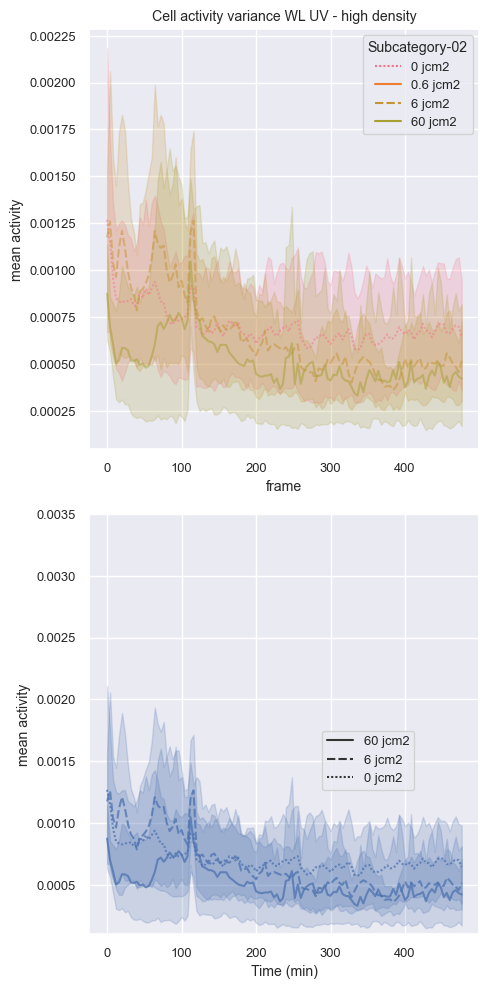

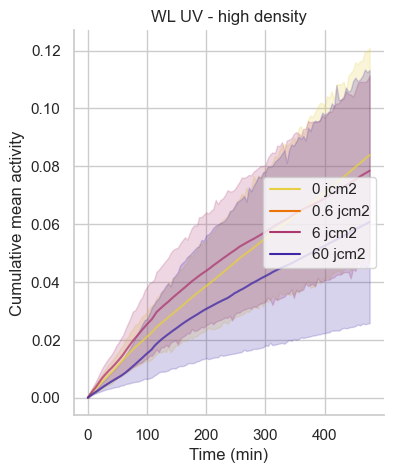

In [12]:
activity_metrics = pd.read_csv(os.path.join(path2results, "data_activity_intensity.csv"))

# If the data was organised as indicated, Subcategory-01 corresponds to the wavelength (e.g., 385nm illumination)
wavelength = np.unique(activity_metrics["Subcategory-01"])

hue="Subcategory-02" # It's the variable that corresponds to the light dose (e.g., 60 J/cm2)
hue_order = ['0 jcm2', '6 jcm2', '60 jcm2'] # Establish your own order if needed.
ylim = [0.0001, 0.0035] # This is the y-axis limit to plot everything similarly. Addapt it as needed. 
format_extension = 'pdf' # Format to save the plots.

for w in wavelength:
    activity_w = activity_metrics[activity_metrics["Subcategory-01"]==w].reset_index(drop=True)    

    # Plot the temporal distribution of the activity
    y = "mean activity" # Variable to display
    display.conditions_with_aggregates(activity_w, y,
                               f"Cell activity variance {w}",
                               os.path.join(path2results, "plots"),
                               f"activity_variance_{w}.png",
                               hue=hue, 
                               hue_order=hue_order,
                               ylim = ylim)
    
    ## Plot additive activity
    activity_w_dataframe, activity_w = cumulative_activity(activity_w, y, use_starting_point="None", starting_point=0)
    
    y_var = f"Cumulative {y}"
    name = "cell_cumulative_activity_{0}.{1}".format(w, format_extension)
    title = f"{w}"
    display.conditions(activity_w, y_var, 
                       title, 
                       hue,
                       os.path.join(path2results, "plots"),
                       name, 
                       hue_order=hue_order,
                       palette=sns.color_palette("CMRmap_r", len(hue_order)), # change the palette if desired
                       figsize=(4, 5)) # Change the aspect ratio of the figure if desired 
    

### 2.2 Display the cummulative cell activity at a specific timepoint
- `t`: The time-point at which the differences in activity will be evaluated, in the same unit as the frame_rate given (e.g., minutes)
- `variable`: The variable for which the proportional differences will be calculated. In our case it was `'Cumulative mean activity'`.
- `grouping_variable`: The differences are calculated on average by replica (the grouping variable). In our case, following the data structure, it should be `"Subcategory-00"`.
- `reference_variable`: The variable in the data-frame that encodes the conditions and that will be displayed. In our case, it is `"Subcategory-02"`.
- `reference_category`: The reference condition used to calculate the differences. In our case, it is the control `'0 J/cm2'`.
- `unique_id_var`: We use it to identify individual videos and get statistics across them. In our case, it is `"video_name"`.
- `add_columns`: List of the columns from the original dataset that we want to preserve in the new `activity_diff` data frame.
- `wl_order`: Indicate the order in which the columns of the composed plot will be displayed. In our case, it is the Wavelength chosen. For example: `['WL UV - high density', 'WL 475 - high density', 'WL 630 - high density'] `. One could alternatively choose another one. Run `np.unique(activity_metrics["Subcategory-01"])` to know the choices. 
- `hue_order`: Indicate the order of the conditions in which the data should be displayed. For example `"['0 jcm2', '6 jcm2', '60 jcm2']"`. To recover the conditions available in the data, you can run `np.unique(activity_metrics["Subcategory-02"])`.
- `y_lim`: The boundary limits to display all the data in the same interval. For example `[-25, 100]`.
- `format_extension`: Whether to save the plots as pdf (`"pdf"`) or PNG (`"png"`).

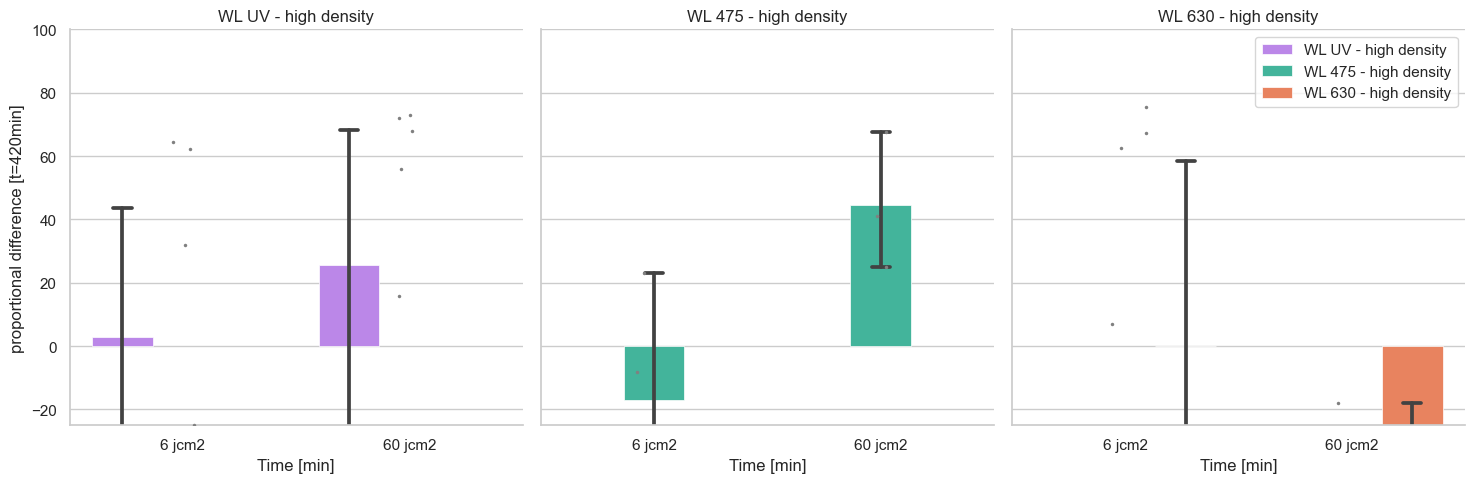

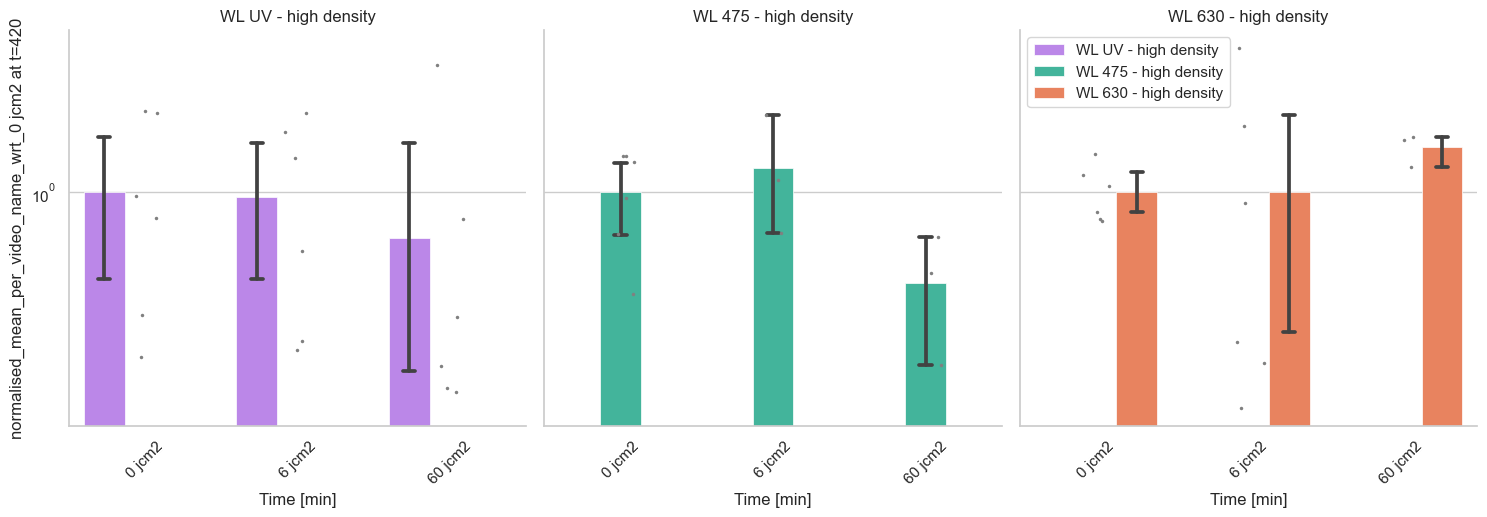

In [20]:
t = 420
activity_metrics = pd.read_csv(os.path.join(path2results, "data_activity_intensity.csv"))
## Calculate the cumulative cell activity
y = "mean activity"
activity_dataframe, activity = cumulative_activity(activity_metrics, y, use_starting_point="None")
### Filter out the data for a specfic timepoint t.
activity = activity.loc[lambda activity: activity["frame"]==t]

variable = 'Cumulative mean activity'
grouping_variable="Subcategory-00"
reference_category='0 jcm2'
reference_variable="Subcategory-02"
unique_id_var = "video_name"
add_columns = ["Subcategory-01"]
## Calculate the deviations in cell activity
activity_diff = estimate_proportional_deviations(activity,
                                                 variable,
                                                 reference_category=reference_category,
                                                 reference_variable=reference_variable,
                                                 unique_id_var=unique_id_var,
                                                 grouping_variable=grouping_variable,
                                                 add_columns=add_columns) ## add




palette_colours = ['#BC77F8', '#30C7A6', '#FF7848'] # colors for the wavelengths
wl_order = ['WL UV - high density', 'WL 475 - high density', 'WL 630 - high density'] # Column order in the plot, corresponding to the wavelengths
wl_column = "Subcategory-01" # Name of the category to consider when plotting the columns.
hue_order = ['6 jcm2', '60 jcm2'] # Order in which the conditions will be displayed.
y_lim = [-25, 100] # Choose the y-axis limits in the plot
format_extension = "pdf" # Choose between "pdf" and "png"

# ------------------------
# PLOT: Proportional differences
# ------------------------
g = sns.catplot(
    activity_diff, kind="bar",
    x=reference_variable, 
    y=f"proportional_difference_per_{unique_id_var}",
    col=wl_column,
    hue=wl_column,
    order=hue_order,
    col_order=wl_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    hue_order=wl_order, legend=False
)
g.map_dataframe(sns.stripplot,
            x=reference_variable,
            y=f"proportional_difference_per_{unique_id_var}",
            order=hue_order,
            jitter=True,
            dodge=False,
            marker='.',
            color="gray",
            alpha=1)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper right')
g.set(xlabel="Time [min]", ylabel=f"proportional difference [t={t}min]", ylim=y_lim)
g.set_titles("{col_name}")
g.savefig(os.path.join(path2results, "plots", f"barplots_{variable}_differences_t{t}.{format_extension}"), format=format_extension, transparent=True)
plt.show()

# ------------------------
# PLOT: Average activity
# ------------------------
hue_order = ['0 jcm2', '6 jcm2', '60 jcm2'] # Order in which the conditions will be displayed.
g = sns.catplot(
    activity_diff, kind="bar",
    x=reference_variable, y=f"normalised_mean_per_video_name_wrt_{reference_category}",
    col=wl_column,
    hue=wl_column,
    #height=10, aspect=1,
    order=hue_order,
    col_order=wl_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    hue_order=wl_order, 
    legend=False
)
g.map_dataframe(sns.stripplot,
        x=reference_variable,
        y=f"normalised_mean_per_video_name_wrt_{reference_category}",
        #hue="Subcategory-00",
        order=hue_order,
        jitter=True,
        dodge=False,
        #palette=palette_colours,
        marker='.',
        color="gray",
        alpha=1)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper left')
g.set_xticklabels(rotation=45)
g.set(xlabel="Time [min]", ylabel=f"normalised_mean_per_video_name_wrt_{reference_category} at t={t}", yscale="log")
g.set_titles("{col_name}")
g.savefig(os.path.join(path2results, "plots", f"barplots_normalised_{variable}_t{t}.{format_extension}"), format=format_extension, transparent=True)

plt.show()

### 2.3 Obtain basic statistics


#### Mean values

In [14]:
activity_diff.groupby(["Subcategory-01", "Subcategory-02"]).mean()


mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                  
WL 475 - high density 0 jcm2                               0.024459   
                      6 jcm2                               0.025651   
                      60 jcm2                              0.014967   
WL 630 - high density 0 jcm2                               0.124980   
                      6 jcm2                               0.051249   
                      60 jcm2                              0.023008   
WL UV - high density  0 jcm2                               0.074259   
                      6 jcm2                               0.071447   
                      60 jcm2                              0.054657   

                                      Subcategory-00 mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                                 
WL 475 - high density 0 jcm2                                              0.024459   
                      6 jcm2                                              0.025651   
                      60 jcm2                                             0.014967   
WL 630 - high density 0 jcm2                                              0.124980   
                      6 jcm2                                              0.051249   
                      60 jcm2                                             0.023008   
WL UV - high density  0 jcm2                                              0.074259   
                      6 jcm2                                              0.071447   
                      60 jcm2                                             0.054657   

                                      normalised_mean_per_video_name_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                              
WL 475 - high density 0 jcm2                                           1.000000   
                      6 jcm2                                           1.171184   
                      60 jcm2                                          0.553984   
WL 630 - high density 0 jcm2                                           1.000000   
                      6 jcm2                                           0.999044   
                      60 jcm2                                          1.340826   
WL UV - high density  0 jcm2                                           1.000000   
                      6 jcm2                                           0.970500   
                      60 jcm2                                          0.742947   

                                      normalised_mean_per_Subcategory-00_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                                  
WL 475 - high density 0 jcm2                                               1.000000   
                      6 jcm2                                               1.171184   
                      60 jcm2                                              0.553984   
WL 630 - high density 0 jcm2                                               1.000000   
                      6 jcm2                                               0.999044   
                      60 jcm2                                              1.340826   
WL UV - high density  0 jcm2                                               1.000000   
                      6 jcm2                                               0.970500   
                      60 jcm2                                              0.742947   

                                      difference_per_video_name  \
Subcategory-01        Subcategory-02                              
WL 475 - high density 0 jcm2                      -1.445603e-18   
                      6 jcm2                      -3.749275e-03   
                      60 jcm2                      1.204985e-02   
WL 630 - high density 0 jcm2                       8.673617e-18   
                      6 jcm2       

#### Standard deviation values

In [15]:
print("Standard deviation values of all the calculated metrics")
activity_diff.groupby(["Subcategory-01", "Subcategory-02"]).std()

Standard deviation values of all the calculated metrics


mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                  
WL 475 - high density 0 jcm2                               0.008496   
                      6 jcm2                               0.009918   
                      60 jcm2                              0.005817   
WL 630 - high density 0 jcm2                               0.119998   
                      6 jcm2                               0.027891   
                      60 jcm2                              0.002397   
WL UV - high density  0 jcm2                               0.043561   
                      6 jcm2                               0.041423   
                      60 jcm2                              0.057703   

                                      Subcategory-00 mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                                 
WL 475 - high density 0 jcm2                                              0.002801   
                      6 jcm2                                              0.000000   
                      60 jcm2                                             0.000000   
WL 630 - high density 0 jcm2                                              0.118111   
                      6 jcm2                                              0.024529   
                      60 jcm2                                             0.000000   
WL UV - high density  0 jcm2                                              0.001365   
                      6 jcm2                                              0.039280   
                      60 jcm2                                             0.032517   

                                      normalised_mean_per_video_name_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                              
WL 475 - high density 0 jcm2                                           0.311515   
                      6 jcm2                                           0.452856   
                      60 jcm2                                          0.215296   
WL 630 - high density 0 jcm2                                           0.181902   
                      6 jcm2                                           0.914286   
                      60 jcm2                                          0.139664   
WL UV - high density  0 jcm2                                           0.586677   
                      6 jcm2                                           0.574903   
                      60 jcm2                                          0.793644   

                                      normalised_mean_per_Subcategory-00_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                                  
WL 475 - high density 0 jcm2                                               0.000000   
                      6 jcm2                                               0.000000   
                      60 jcm2                                              0.000000   
WL 630 - high density 0 jcm2                                               0.000000   
                      6 jcm2                                               0.747880   
                      60 jcm2                                              0.000000   
WL UV - high density  0 jcm2                                               0.000000   
                      6 jcm2                                               0.546802   
                      60 jcm2                                              0.451547   

                                      difference_per_video_name  \
Subcategory-01        Subcategory-02                              
WL 475 - high density 0 jcm2                           0.008021   
                      6 jcm2                           0.009918   
                      60 jcm2                          0.005817   
WL 630 - high density 0 jcm2                           0.021197   
                      6 jcm2       